# Mount data from google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
time: 2.07 s (started: 2022-08-05 18:44:28 +00:00)


In [5]:
project_folder='/content/drive/MyDrive/leapGestRecog'

time: 1.42 ms (started: 2022-08-05 18:44:30 +00:00)


In [6]:
import pathlib
data = pathlib.Path(project_folder)

time: 1.1 ms (started: 2022-08-05 18:44:30 +00:00)


# Install/ import libraries

In [1]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.02 ms (started: 2022-08-05 18:44:18 +00:00)


In [2]:
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 6.15 s (started: 2022-08-05 18:44:18 +00:00)


In [3]:
from tensorflow import keras

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

#preprocess.
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

#dl libraraies
from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from numpy import expand_dims
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

import abc
from skimage import io

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

time: 3.2 s (started: 2022-08-05 18:44:24 +00:00)


# Get Data and split data to train & test

In [7]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir(project_folder+'/00'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 6,
 '02_l': 3,
 '03_fist': 0,
 '04_fist_moved': 4,
 '05_thumb': 5,
 '06_index': 2,
 '07_ok': 9,
 '08_palm_moved': 8,
 '09_c': 1,
 '10_down': 7}

time: 8.29 ms (started: 2022-08-05 18:44:30 +00:00)


In [8]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # to count the total number of data points in the dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir(project_folder + '/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # to count the total number of data points for a given gesture for a given person
            for k in os.listdir(project_folder + '/0' + str(i) + '/' + j + '/'): # Loop over the images
                path = project_folder + '/0'  + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size


time: 1min 20s (started: 2022-08-05 18:44:30 +00:00)


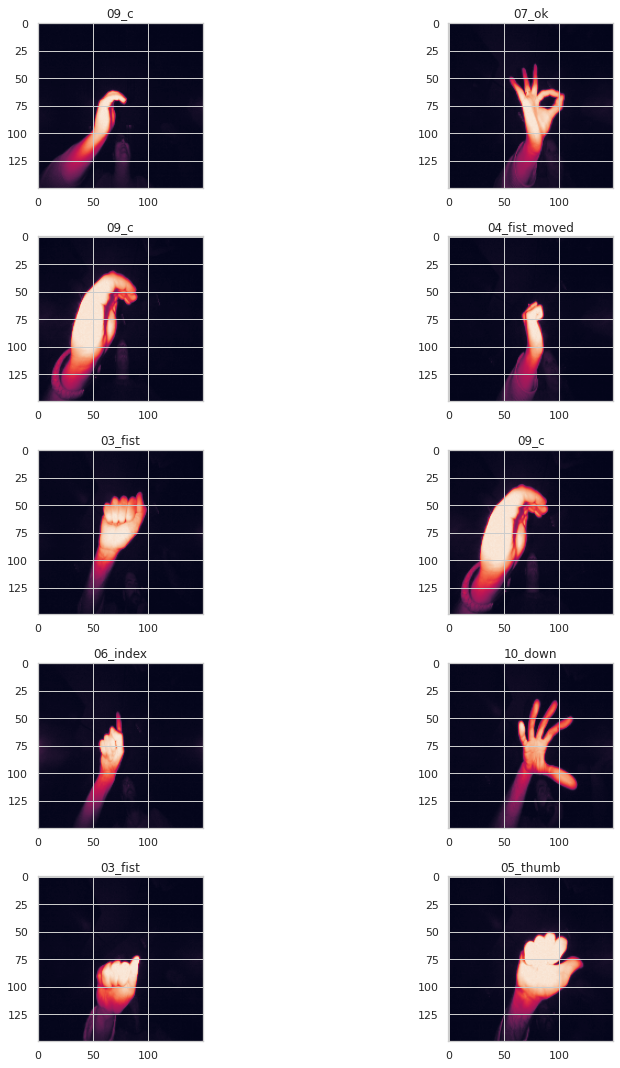

time: 3.12 s (started: 2022-08-05 18:45:50 +00:00)


In [9]:
# check some image
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

In [10]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

time: 536 ms (started: 2022-08-05 18:45:53 +00:00)


In [11]:
# In the first step we will split the data in training and remaining dataset
x_train, x_rem, y_train, y_rem = train_test_split(x_data,y_data,train_size=0.6)

# Now since we want the valid and test size to be equal (20% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)

time: 629 ms (started: 2022-08-05 18:45:54 +00:00)


# Batch size and common variables

In [12]:
batch_size=128
epochs=10
validation_split=0.2

time: 1.24 ms (started: 2022-08-05 18:45:55 +00:00)


In [13]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

time: 9.67 ms (started: 2022-08-05 18:45:55 +00:00)


# Plot graphs

In [14]:
from matplotlib.pyplot import figure

def plotGraph(hist, title):
  plt.title(title+": Loss")
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

  plt.title(title+": Accuracy")
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

time: 8.52 ms (started: 2022-08-05 18:45:55 +00:00)


# Evaluation metrics


In [15]:
def getConfusionMatrix(model, y_test, title):
  y_pred = model.predict(x_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  labels = list(lookup.keys())    
  ax= plt.subplot()

  # labels, title and ticks
  ax.set_title(title+" Confusion Matrix")
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  ax.set_xticklabels(labels, rotation=90);
  ax.set_yticklabels(labels, rotation=0);
  ax.xaxis.set_ticklabels(labels); 
  ax.yaxis.set_ticklabels(labels);

  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);

def getEvaluationScores(model):
  y_pred = model.predict(x_test)
  y_pred = (y_pred > 0.5) 
  f1Score = f1_score(y_test, y_pred, average='micro')
  print("F1 Score : ", f1Score)

  precisionScore = precision_score(y_test, y_pred, pos_label='positive', average='micro')
  recallScore = recall_score(y_test, y_pred, pos_label='positive', average='micro')
  print("Precision Score : ", precisionScore)
  print("Recall Score : ", recallScore)

time: 18.2 ms (started: 2022-08-05 18:45:55 +00:00)


# Base Model (CNN2D) - Fit without Data Augmentation

In [85]:
base_model = Sequential()
base_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
base_model.add(MaxPooling2D(pool_size=(2,2)))


base_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

base_model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

base_model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

base_model.add(Flatten())
base_model.add(Dense(512))
base_model.add(Activation('relu'))
base_model.add(Dense(10, activation = "softmax"))

time: 71.1 ms (started: 2022-08-05 19:06:10 +00:00)


In [86]:
base_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

time: 7.53 ms (started: 2022-08-05 19:06:11 +00:00)


In [87]:
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 18, 18, 96)      

In [88]:
base_model_fit = base_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_valid, y_valid),callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 6s 64ms/step - loss: 0.4122 - accuracy: 0.8663 - val_loss: 0.0146 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 2/10
94/94 [==============================] - 6s 60ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0074 - val_accuracy: 0.9977 - lr: 0.0010
Epoch 3/10
94/94 [==============================] - 6s 60ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0226 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/10
94/94 [==============================] - 6s 60ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 0.0027 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 5/10
94/94 [==============================] - 6s 67ms/step - loss: 1.7579e-04 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 6/10
94/94 [==============================] - 6s 59ms/step - loss: 5.8242e-05 - accuracy: 1.0000 - val_loss: 9.4560e-04 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 7/10
94/94 [==============================] - 6s 60ms/step

[[367   0   0   0   0   0   0   0   0   0]
 [  0 437   0   0   0   0   0   0   0   0]
 [  0   0 398   0   0   0   0   0   0   0]
 [  0   0   0 427   0   0   0   0   0   0]
 [  0   0   0   0 377   0   0   0   0   0]
 [  1   0   0   0   0 373   0   0   0   0]
 [  0   0   0   1   0   0 418   0   0   0]
 [  0   0   0   0   0   0   0 404   0   0]
 [  0   0   0   0   0   0   0   0 388   0]
 [  0   0   0   0   0   0   0   0   0 409]]


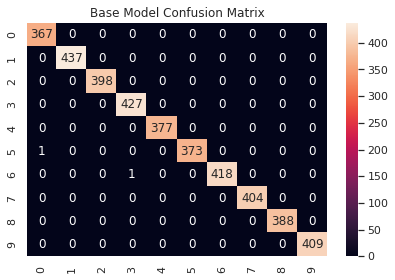

time: 1.46 s (started: 2022-08-05 19:07:09 +00:00)


In [89]:
getConfusionMatrix(base_model, y_test, 'Base Model')

In [90]:
getEvaluationScores(base_model)

F1 Score :  0.9996249531191399
Precision Score :  0.9997499374843711
Recall Score :  0.9995
time: 922 ms (started: 2022-08-05 19:07:10 +00:00)


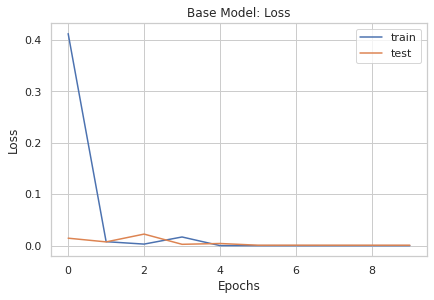

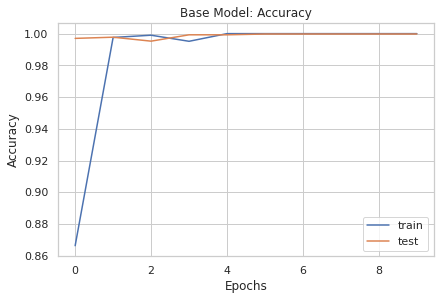

time: 418 ms (started: 2022-08-05 19:07:11 +00:00)


In [91]:
plotGraph(base_model_fit, 'Base Model')

In [92]:
[loss, acc] = base_model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

125/125 [==============================] - 1s 7ms/step - loss: 0.0053 - accuracy: 0.9995
Accuracy:0.9994999766349792
time: 1.2 s (started: 2022-08-05 19:07:12 +00:00)


# Base Model (CNN2D) - Fit with Data Augmentation

In [93]:
base_model_da = Sequential()
base_model_da.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
base_model_da.add(MaxPooling2D(pool_size=(2,2)))


base_model_da.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
base_model_da.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

base_model_da.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
base_model_da.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

base_model_da.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
base_model_da.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

base_model_da.add(Flatten())
base_model_da.add(Dense(512))
base_model_da.add(Activation('relu'))
base_model_da.add(Dense(10, activation = "softmax"))

time: 72.5 ms (started: 2022-08-05 19:07:43 +00:00)


In [94]:
base_model_da.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

time: 6.95 ms (started: 2022-08-05 19:07:43 +00:00)


In [95]:
base_model_da.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 18, 18, 96)      

In [96]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

time: 1.66 ms (started: 2022-08-05 19:07:43 +00:00)


In [97]:
base_model_da_fit = base_model_da.fit(
	x=aug.flow(x_train, y_train, batch_size=batch_size),
	validation_data=(x_valid, y_valid),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/10
93/93 [==============================] - 19s 203ms/step - loss: 1.4424 - accuracy: 0.4866 - val_loss: 0.4703 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 2/10
93/93 [==============================] - 18s 195ms/step - loss: 0.4348 - accuracy: 0.8487 - val_loss: 0.1428 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 3/10
93/93 [==============================] - 18s 195ms/step - loss: 0.2045 - accuracy: 0.9338 - val_loss: 0.0557 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 4/10
93/93 [==============================] - 18s 197ms/step - loss: 0.1361 - accuracy: 0.9566 - val_loss: 0.0257 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 5/10
93/93 [==============================] - 18s 196ms/step - loss: 0.1093 - accuracy: 0.9653 - val_loss: 0.0229 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 6/10
93/93 [==============================] - 18s 197ms/step - loss: 0.0893 - accuracy: 0.9717 - val_loss: 0.0270 - val_accuracy: 0.9942 - lr: 0.0010
Epoch 7/10
93/93 [==============================] - 18s 194ms/st

[[367   0   0   0   0   0   0   0   0   0]
 [  0 436   0   0   1   0   0   0   0   0]
 [  0   0 398   0   0   0   0   0   0   0]
 [  0   0   0 427   0   0   0   0   0   0]
 [  2   1   0   0 374   0   0   0   0   0]
 [  0   0   0   0   0 374   0   0   0   0]
 [  0   0   0   0   0   2 417   0   0   0]
 [  0   0   0   0   0   0   0 404   0   0]
 [  0   1   0   0   0   0   0   0 387   0]
 [  0   0   0   0   0   0   0   0   0 409]]


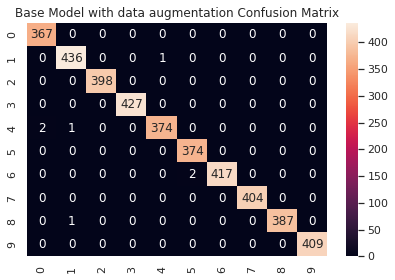

time: 1.47 s (started: 2022-08-05 19:10:47 +00:00)


In [98]:
getConfusionMatrix(base_model_da, y_test, 'Base Model with data augmentation')

In [99]:
getEvaluationScores(base_model_da)

F1 Score :  0.9979989994997498
Precision Score :  0.9984984984984985
Recall Score :  0.9975
time: 917 ms (started: 2022-08-05 19:10:48 +00:00)


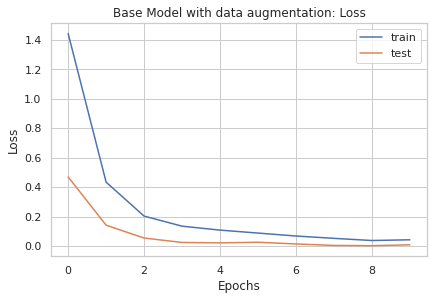

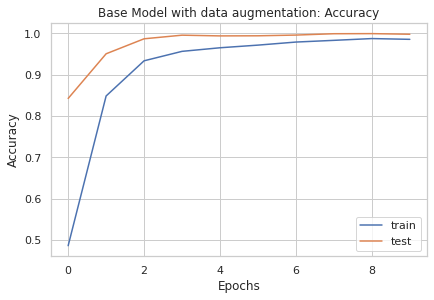

time: 420 ms (started: 2022-08-05 19:10:49 +00:00)


In [100]:
plotGraph(base_model_da_fit, 'Base Model with data augmentation')

In [101]:
[loss, acc] = base_model_da.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

125/125 [==============================] - 1s 7ms/step - loss: 0.0100 - accuracy: 0.9983
Accuracy:0.9982500076293945
time: 1.48 s (started: 2022-08-05 19:10:50 +00:00)


# CNN-LSTM Model - Fit without Data Augmentation

In [102]:
cl_model = Sequential()

cl_model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
cl_model.add(BatchNormalization())
cl_model.add(MaxPooling2D(pool_size=(2,2)))

cl_model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model.add(BatchNormalization())
cl_model.add(MaxPooling2D(pool_size=(2,2)))


cl_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model.add(BatchNormalization())
cl_model.add(MaxPooling2D(pool_size=(2,2)))

cl_model.add(Conv2D(filters =128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model.add(BatchNormalization())
cl_model.add(MaxPooling2D(pool_size=(2,2)))

cl_model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model.add(BatchNormalization())
cl_model.add(MaxPooling2D(pool_size=(2,2)))

cl_model.add(TimeDistributed(Flatten()))

cl_model.add(LSTM(128))
cl_model.add(Dropout(0.25))

cl_model.add(Dense(128,activation='relu'))
cl_model.add(Dropout(0.5))

cl_model.add(Dense(10, activation = "softmax"))

cl_model.add(Activation('relu'))

time: 260 ms (started: 2022-08-05 19:11:04 +00:00)


In [103]:
cl_model.compile(optimizer=Adam(lr=0.002),loss='categorical_crossentropy',metrics=['accuracy'])

time: 6.96 ms (started: 2022-08-05 19:11:05 +00:00)


In [104]:
cl_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 150, 150, 16)      160       
                                                                 
 batch_normalization_23 (Bat  (None, 150, 150, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_24 (Bat  (None, 75, 75, 32)       128       
 chNormalization)                                                
                                                      

In [105]:
cl_model_fit = cl_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_valid, y_valid),callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 9s 63ms/step - loss: 0.6246 - accuracy: 0.8017 - val_loss: 3.6009 - val_accuracy: 0.0990 - lr: 0.0020
Epoch 2/10
94/94 [==============================] - 5s 57ms/step - loss: 0.0214 - accuracy: 0.9958 - val_loss: 6.1327 - val_accuracy: 0.0990 - lr: 0.0020
Epoch 3/10
94/94 [==============================] - 5s 57ms/step - loss: 0.0176 - accuracy: 0.9966 - val_loss: 7.7557 - val_accuracy: 0.0990 - lr: 0.0020
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9966
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
94/94 [==============================] - 5s 57ms/step - loss: 0.0162 - accuracy: 0.9966 - val_loss: 9.5483 - val_accuracy: 0.0990 - lr: 0.0020
Epoch 5/10
94/94 [==============================] - 5s 57ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 6.8244 - val_accuracy: 0.1782 - lr: 2.0000e-04
Epoch 6/10
94/94 [==============================] - 5s 57ms/step -

[[367   0   0   0   0   0   0   0   0   0]
 [  0 436   0   0   0   1   0   0   0   0]
 [  0   0 398   0   0   0   0   0   0   0]
 [  0   0   0 427   0   0   0   0   0   0]
 [  0   0   0   0 377   0   0   0   0   0]
 [  2   0   0   0   0 372   0   0   0   0]
 [  0   0   0   0   0   0 419   0   0   0]
 [  0   0   0   0   0   0   0 404   0   0]
 [  0   0   0   0   0   0   0   0 388   0]
 [  0   0   0   0   0   0   0   0   0 409]]


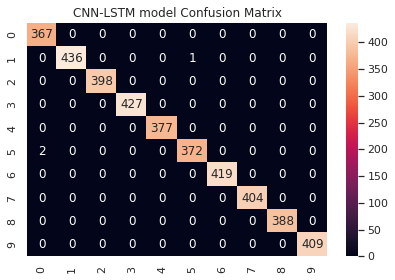

time: 1.7 s (started: 2022-08-05 19:12:03 +00:00)


In [106]:
getConfusionMatrix(cl_model, y_test, 'CNN-LSTM model')

In [107]:
getEvaluationScores(cl_model)

F1 Score :  0.99925
Precision Score :  0.99925
Recall Score :  0.99925
time: 901 ms (started: 2022-08-05 19:12:05 +00:00)


In [108]:
[loss, acc] = cl_model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

125/125 [==============================] - 1s 6ms/step - loss: 0.0039 - accuracy: 0.9992
Accuracy:0.9992499947547913
time: 1.38 s (started: 2022-08-05 19:12:06 +00:00)


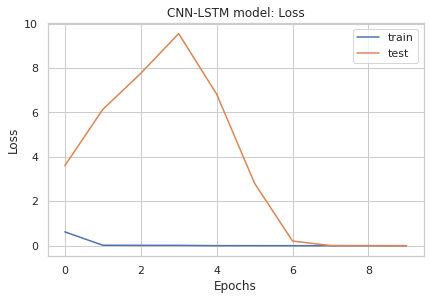

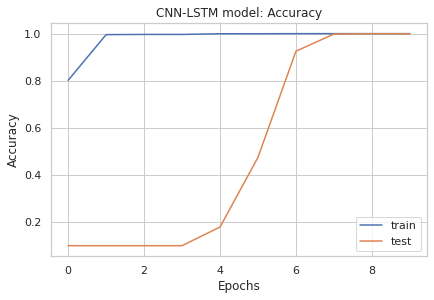

time: 408 ms (started: 2022-08-05 19:12:07 +00:00)


In [109]:
plotGraph(cl_model_fit, 'CNN-LSTM model')

# CNN-LSTM Model - Fit with Data augmentation

In [110]:
cl_model_da = Sequential()

cl_model_da.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
cl_model_da.add(BatchNormalization())
cl_model_da.add(MaxPooling2D(pool_size=(2,2)))

cl_model_da.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model_da.add(BatchNormalization())
cl_model_da.add(MaxPooling2D(pool_size=(2,2)))


cl_model_da.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model_da.add(BatchNormalization())
cl_model_da.add(MaxPooling2D(pool_size=(2,2)))

cl_model_da.add(Conv2D(filters =128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model_da.add(BatchNormalization())
cl_model_da.add(MaxPooling2D(pool_size=(2,2)))

cl_model_da.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cl_model_da.add(BatchNormalization())
cl_model_da.add(MaxPooling2D(pool_size=(2,2)))

cl_model_da.add(TimeDistributed(Flatten()))

cl_model_da.add(LSTM(128))
cl_model_da.add(Dropout(0.25))

cl_model_da.add(Dense(128,activation='relu'))
cl_model_da.add(Dropout(0.5))

cl_model_da.add(Dense(10, activation = "softmax"))

cl_model_da.add(Activation('relu'))

time: 251 ms (started: 2022-08-05 19:12:10 +00:00)


In [111]:
cl_model_da.compile(optimizer=Adam(lr=0.002),loss='categorical_crossentropy',metrics=['accuracy'])

time: 7.25 ms (started: 2022-08-05 19:12:11 +00:00)


In [112]:
cl_model_da.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 150, 150, 16)      160       
                                                                 
 batch_normalization_28 (Bat  (None, 150, 150, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_29 (Bat  (None, 75, 75, 32)       128       
 chNormalization)                                                
                                                     

In [113]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

time: 1.78 ms (started: 2022-08-05 19:12:11 +00:00)


In [114]:
cl_model_da_fit = cl_model_da.fit(
	x=aug.flow(x_train, y_train, batch_size=batch_size),
	validation_data=(x_valid, y_valid),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/10
93/93 [==============================] - 22s 204ms/step - loss: 1.7494 - accuracy: 0.3640 - val_loss: 3.1160 - val_accuracy: 0.1095 - lr: 0.0020
Epoch 2/10
93/93 [==============================] - 19s 200ms/step - loss: 0.5522 - accuracy: 0.8107 - val_loss: 2.6621 - val_accuracy: 0.1047 - lr: 0.0020
Epoch 3/10
93/93 [==============================] - 18s 198ms/step - loss: 0.2139 - accuracy: 0.9388 - val_loss: 2.7323 - val_accuracy: 0.0983 - lr: 0.0020
Epoch 4/10
93/93 [==============================] - 19s 199ms/step - loss: 0.1297 - accuracy: 0.9629 - val_loss: 2.4743 - val_accuracy: 0.3175 - lr: 0.0020
Epoch 5/10
93/93 [==============================] - 18s 198ms/step - loss: 0.0852 - accuracy: 0.9773 - val_loss: 1.6570 - val_accuracy: 0.3740 - lr: 0.0020
Epoch 6/10
93/93 [==============================] - 18s 197ms/step - loss: 0.0689 - accuracy: 0.9810 - val_loss: 0.6302 - val_accuracy: 0.8493 - lr: 0.0020
Epoch 7/10
93/93 [==============================] - 19s 200ms/st

[[366   0   0   0   1   0   0   0   0   0]
 [  0 436   0   0   0   0   0   0   1   0]
 [  0   0 398   0   0   0   0   0   0   0]
 [  0   0   1 426   0   0   0   0   0   0]
 [  6   1   0   0 370   0   0   0   0   0]
 [  1   1   0   0   0 372   0   0   0   0]
 [  4   0   2   0   0   0 412   0   0   1]
 [  0   0   0   0   0   0   0 398   6   0]
 [  0   0   0   0   0   0   0   0 388   0]
 [  0   0   0   0   0   0   0   0   0 409]]


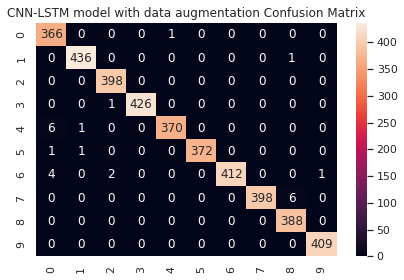

time: 1.7 s (started: 2022-08-05 19:15:20 +00:00)


In [115]:
getConfusionMatrix(cl_model_da, y_test, 'CNN-LSTM model with data augmentation')

In [116]:
getEvaluationScores(cl_model_da)

F1 Score :  0.99375
Precision Score :  0.99375
Recall Score :  0.99375
time: 887 ms (started: 2022-08-05 19:15:22 +00:00)


In [117]:
[loss, acc] = cl_model_da.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

125/125 [==============================] - 1s 6ms/step - loss: 0.0205 - accuracy: 0.9937
Accuracy:0.9937499761581421
time: 967 ms (started: 2022-08-05 19:15:23 +00:00)


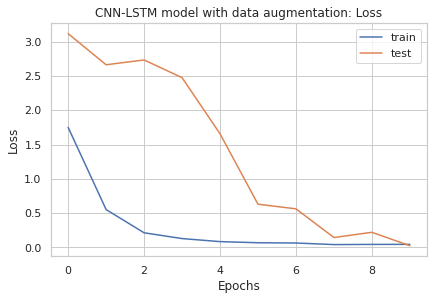

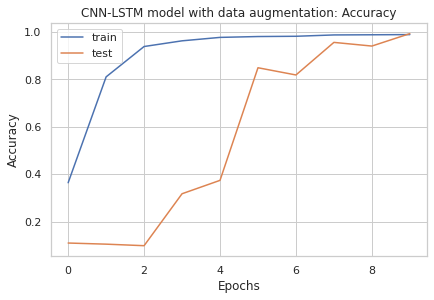

time: 422 ms (started: 2022-08-05 19:15:24 +00:00)


In [118]:
plotGraph(cl_model_da_fit, 'CNN-LSTM model with data augmentation')

# CNN-GRU Model - Fit without Data Augmentation

In [119]:
cg_model = Sequential()

cg_model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
cg_model.add(BatchNormalization())
cg_model.add(MaxPooling2D((2, 2)))
        
cg_model.add(Conv2D(32, (3, 3) , padding='same', activation='relu'))
cg_model.add(BatchNormalization())
cg_model.add(MaxPooling2D((2, 2)))
        
cg_model.add(Conv2D(64, (3, 3) , padding='same', activation='relu'))
cg_model.add(BatchNormalization())
cg_model.add(MaxPooling2D((2, 2)))
        
cg_model.add(Conv2D(128, (3, 3) , padding='same', activation='relu'))
cg_model.add(BatchNormalization())
cg_model.add(MaxPooling2D((2, 2)))
        

cg_model.add(TimeDistributed(Flatten()))


cg_model.add(GRU(128))
cg_model.add(Dropout(0.25))
        
cg_model.add(Dense(128,activation='relu'))
cg_model.add(Dropout(0.25))
        
cg_model.add(Dense(10, activation='softmax'))


time: 300 ms (started: 2022-08-05 19:15:56 +00:00)


In [120]:
cg_model.compile(optimizer=Adam(lr=0.002),loss='categorical_crossentropy',metrics=['accuracy'])

time: 6.89 ms (started: 2022-08-05 19:15:57 +00:00)


In [121]:
cg_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 150, 150, 16)      160       
                                                                 
 batch_normalization_33 (Bat  (None, 150, 150, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_34 (Bat  (None, 75, 75, 32)       128       
 chNormalization)                                                
                                                     

In [122]:
cg_model_fit = cg_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_valid, y_valid),callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 7s 54ms/step - loss: 0.6370 - accuracy: 0.7967 - val_loss: 3.5724 - val_accuracy: 0.1128 - lr: 0.0020
Epoch 2/10
94/94 [==============================] - 4s 47ms/step - loss: 0.0193 - accuracy: 0.9963 - val_loss: 3.4690 - val_accuracy: 0.1115 - lr: 0.0020
Epoch 3/10
94/94 [==============================] - 4s 47ms/step - loss: 0.0083 - accuracy: 0.9983 - val_loss: 3.6932 - val_accuracy: 0.1115 - lr: 0.0020
Epoch 4/10
94/94 [==============================] - 4s 47ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 4.1578 - val_accuracy: 0.1340 - lr: 0.0020
Epoch 5/10
93/94 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9997
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
94/94 [==============================] - 4s 47ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 3.8593 - val_accuracy: 0.1447 - lr: 0.0020
Epoch 6/10
94/94 [==============================] - 4s 47ms/step - los

[[367   0   0   0   0   0   0   0   0   0]
 [  0 436   0   0   0   1   0   0   0   0]
 [  0   0 398   0   0   0   0   0   0   0]
 [  0   0   0 427   0   0   0   0   0   0]
 [  0   0   0   0 377   0   0   0   0   0]
 [  2   0   0   0   0 372   0   0   0   0]
 [  0   0   0   0   0   0 419   0   0   0]
 [  0   0   0   0   0   0   0 404   0   0]
 [  0   0   0   0   0   0   0   0 388   0]
 [  0   0   0   0   0   0   0   0   0 409]]


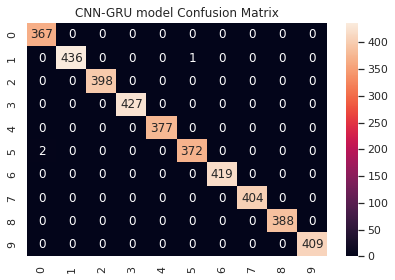

time: 1.75 s (started: 2022-08-05 19:16:44 +00:00)


In [123]:
getConfusionMatrix(cg_model, y_test, 'CNN-GRU model')

In [124]:
getEvaluationScores(cg_model)

F1 Score :  0.9993749218652332
Precision Score :  0.9994998749687422
Recall Score :  0.99925
time: 1.56 s (started: 2022-08-05 19:16:46 +00:00)


In [125]:
[loss, acc] = cg_model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

125/125 [==============================] - 1s 6ms/step - loss: 0.0026 - accuracy: 0.9992
Accuracy:0.9992499947547913
time: 1.36 s (started: 2022-08-05 19:16:48 +00:00)


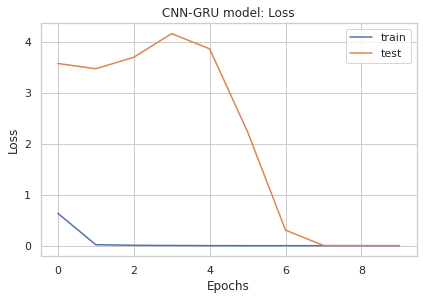

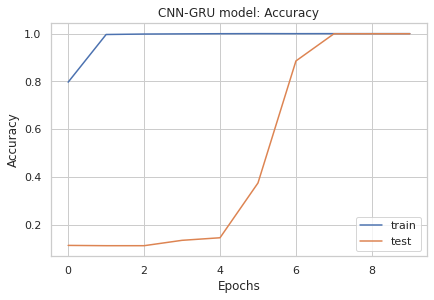

time: 397 ms (started: 2022-08-05 19:16:49 +00:00)


In [126]:
plotGraph(cg_model_fit, 'CNN-GRU model')

# CNN-GRU Model - Fit with Data Augmentation

In [127]:
cg_model_da = Sequential()

cg_model_da.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
cg_model_da.add(BatchNormalization())
cg_model_da.add(MaxPooling2D((2, 2)))
        
cg_model_da.add(Conv2D(32, (3, 3) , padding='same', activation='relu'))
cg_model_da.add(BatchNormalization())
cg_model_da.add(MaxPooling2D((2, 2)))
        
cg_model_da.add(Conv2D(64, (3, 3) , padding='same', activation='relu'))
cg_model_da.add(BatchNormalization())
cg_model_da.add(MaxPooling2D((2, 2)))
        
cg_model_da.add(Conv2D(128, (3, 3) , padding='same', activation='relu'))
cg_model_da.add(BatchNormalization())
cg_model_da.add(MaxPooling2D((2, 2)))
        

cg_model_da.add(TimeDistributed(Flatten()))


cg_model_da.add(GRU(128))
cg_model_da.add(Dropout(0.25))
        
cg_model_da.add(Dense(128,activation='relu'))
cg_model_da.add(Dropout(0.25))
        
cg_model_da.add(Dense(10, activation='softmax'))


time: 299 ms (started: 2022-08-05 19:17:25 +00:00)


In [128]:
cg_model_da.compile(optimizer=Adam(lr=0.002),loss='categorical_crossentropy',metrics=['accuracy'])

time: 6.95 ms (started: 2022-08-05 19:17:25 +00:00)


In [129]:
cg_model_da.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 150, 150, 16)      160       
                                                                 
 batch_normalization_37 (Bat  (None, 150, 150, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_38 (Bat  (None, 75, 75, 32)       128       
 chNormalization)                                                
                                                     

In [130]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

time: 1.3 ms (started: 2022-08-05 19:17:25 +00:00)


In [131]:
cg_model_da_fit = cg_model_da.fit(
	x=aug.flow(x_train, y_train, batch_size=batch_size),
	validation_data=(x_valid, y_valid),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/10
93/93 [==============================] - 21s 201ms/step - loss: 1.6219 - accuracy: 0.3857 - val_loss: 4.5957 - val_accuracy: 0.0990 - lr: 0.0020
Epoch 2/10
93/93 [==============================] - 18s 193ms/step - loss: 0.4725 - accuracy: 0.8276 - val_loss: 3.2835 - val_accuracy: 0.0990 - lr: 0.0020
Epoch 3/10
93/93 [==============================] - 18s 193ms/step - loss: 0.1864 - accuracy: 0.9420 - val_loss: 3.0304 - val_accuracy: 0.0990 - lr: 0.0020
Epoch 4/10
93/93 [==============================] - 18s 194ms/step - loss: 0.1130 - accuracy: 0.9664 - val_loss: 3.1738 - val_accuracy: 0.1238 - lr: 0.0020
Epoch 5/10
93/93 [==============================] - 18s 193ms/step - loss: 0.0762 - accuracy: 0.9760 - val_loss: 2.9082 - val_accuracy: 0.2465 - lr: 0.0020
Epoch 6/10
93/93 [==============================] - 18s 194ms/step - loss: 0.0774 - accuracy: 0.9757 - val_loss: 0.7845 - val_accuracy: 0.7705 - lr: 0.0020
Epoch 7/10
93/93 [==============================] - 18s 193ms/st

[[367   0   0   0   0   0   0   0   0   0]
 [  0 297   0   0   0   1   0 138   0   1]
 [  0   0 356   0   0   9   0   2  31   0]
 [  3   0   1 405   0   1   0  17   0   0]
 [  3   0   0   0 374   0   0   0   0   0]
 [  0   0   0   0   0 374   0   0   0   0]
 [ 17   0   0   0   1  10 390   0   0   1]
 [  0   0   0   0   0   0   0 404   0   0]
 [  0   0   0   0   6   0   0   0 382   0]
 [  0   0   0   0   0   0   0   0   0 409]]


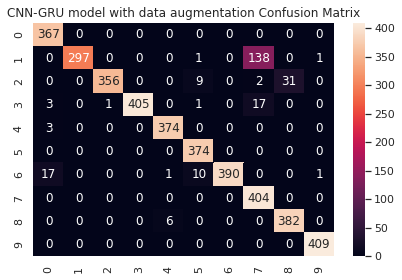

time: 1.6 s (started: 2022-08-05 19:20:29 +00:00)


In [132]:
getConfusionMatrix(cg_model_da, y_test, 'CNN-GRU model with data augmentation')

In [133]:
getEvaluationScores(cg_model_da)

F1 Score :  0.939268200678989
Precision Score :  0.9448520111307868
Recall Score :  0.93375
time: 775 ms (started: 2022-08-05 19:20:30 +00:00)


In [134]:
[loss, acc] = cg_model_da.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

125/125 [==============================] - 1s 5ms/step - loss: 0.2126 - accuracy: 0.9395
Accuracy:0.9394999742507935
time: 893 ms (started: 2022-08-05 19:20:31 +00:00)


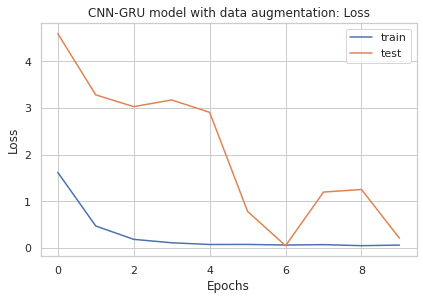

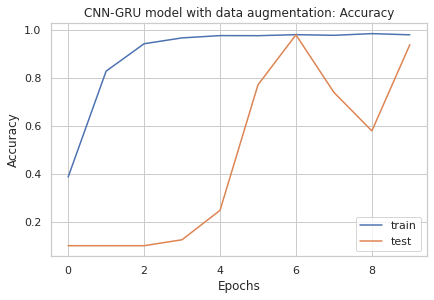

time: 410 ms (started: 2022-08-05 19:20:32 +00:00)


In [135]:
plotGraph(cg_model_da_fit, 'CNN-GRU model with data augmentation')